**In this project, you need to program a bot that automatically trades stocks for you. The bot
should use sophisticated machine learning algorithms to predict future stock prices and then
decide to buy or sell the stock. You should test the performance of the bot empirically over a
certain time frame and for different stocks.**


#### Data
You can collect your own stock price data for which you want to train the algorithms.
The example data set are daily stock prices of Apple from January to the end of March 2021.
You can use the same set and/or another of your choosing.

#### Tasks
• Choose a stock/index/currency/commodity/etc. and collect price data for a certain time
frame that you want to use to train and test the algorithms. To train these algorithms
you should have a sufficient amount of data points. Daily returns are easily accessible
but you can also try to look at intra-day data and go the high-frequency trading route.

• As a benchmark, come up with some easy rules to buy and sell the stock (i.e. buy the
stock if it was down the day before, ...). Also implement an algorithm that buys the stock
at random. Test the performance of the strategies empirically.

• Now use more sophisticated approaches to predict the future stock price and let the
trading bot invest based on these forecasts. This is a typical time series application. Check
if the assumptions of the models hold. Find the best time series model and implement it
into the trading bot. Show the performance.

• Try to use other machine learning algorithms to predict stock prices and compare their
performance.

• Your trading bot should work well for your stock and time frame now. What about
another time frame? Or another stock/index?

• It probably won’t perform as well as it did before and you would need to adjust the
algorithm’s parameters or change it altogether. It requires a lot of time to do that
manually every time. Write a program that automatically finds the best approach for
any given asset and time frame to optimize your trading bot.

#### Possible Extensions:
• Assume that your trading bot can also sell short instead of just buying assets.
• In a real setting, you would also need to consider trading fees and probably also taxes.
What would change? How can you take this into account when optimizing your bot?

# 1. Import Libraries and Data Preprocessing

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
%matplotlib inline
from datetime import timedelta
from pandas.plotting import autocorrelation_plot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import random

# Import libraries for Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Import libraries for XGBoost
from xgboost import XGBRegressor
import xgboost as xgb

# preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

For measuring the performance of models we had created metrics like - 
* MAPE - Mean absolute percentage error
* WMAPE - Weighted mean absolute percentage error

In [3]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = actual[j] - predicted[j]
        else:
            rej[j] = predicted[j]
            
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100

def weighted_mean_absolute_percentage_error(y_true, y_pred):
    if sum(y_true) == 0:
        denominator = 1
    else:
        denominator = sum(y_true)
    return (sum(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))))*100/denominator
    

## 1.1 Import data for stocks

In [203]:
# here we are using apples stock data
apple = pd.read_csv("AAPL_returns.csv")

## To calculate the return, we already have returns in the dataset
#apple['stock_return'] = ( apple['Adj Close'] - apple['Adj Close'].shift(1) )/(apple['Adj Close'].shift(1))

apple = apple.dropna()
# Convert date to DateTime format
apple['Date'] = pd.to_datetime(apple['Date'])
apple.tail(3)

,Date,High,Low,Open,Close,Volume,Adj Close,returns
59,2021-03-30,120.400002,118.860001,120.110001,119.900002,85671900.0,118.654793,-0.012274
60,2021-03-31,123.519997,121.150002,121.650002,122.150002,118323800.0,120.881432,0.018766
61,2021-04-01,124.180000,122.489998,123.660004,123.000000,75089100.0,121.722595,0.006959


## 1.2 Visualization of Adj Close and Returns values - Trend and Seasonality

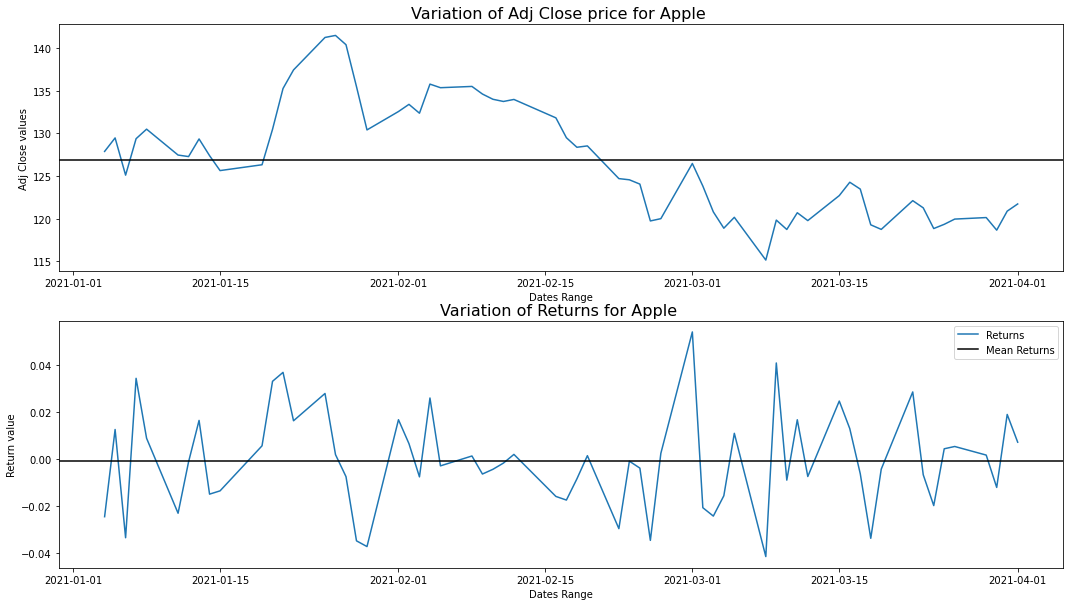

In [204]:
fig, axes = plt.subplots(2,1, figsize = (18,10))
sns.lineplot(x='Date', y='Adj Close', data=apple, ax=axes[0])
axes[0].axhline(apple['Adj Close'].mean(), color='k')
axes[0].set_xlabel('Dates Range')
axes[0].set_ylabel('Adj Close values')
axes[0].set_title("Variation of Adj Close price for Apple ", fontsize = 16)
plt.legend(('Adj Close Price','Mean Adj Close Price'));

sns.lineplot(x='Date', y='returns', data=apple, ax=axes[1])
axes[1].axhline(apple['returns'].mean(), color='k')
axes[1].set_xlabel('Dates Range')
axes[1].set_ylabel('Return value')
axes[1].set_title("Variation of Returns for Apple ", fontsize = 16)
plt.legend(('Returns','Mean Returns'));

* In comparision to Adj Close price, return is quite flactuating and 
* Trends and seasonality is not visible from the graph for returns

In [205]:
# Testing For Stationarity

#Null Hypothesis H0 = If failed to be rejected, it suggests the time series has a unit root, 
#                     meaning it is non-stationary

#Alternative Hypothesis H1 = The null hypothesis is rejected and suggests the time series 
#                            does not have a unit root, meaning it is stationary

def adfuller_test(returns):
    result=adfuller(returns)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(apple['returns'])

ADF Test Statistic : -8.139094784238278
p-value : 1.039806444152943e-12
#Lags Used : 0
Number of Observations Used : 61
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


We get the strong evidence that our data is stationary, which indicate its mean and variance are not varying with time and we can use tradition time series algorithm for forecasting.

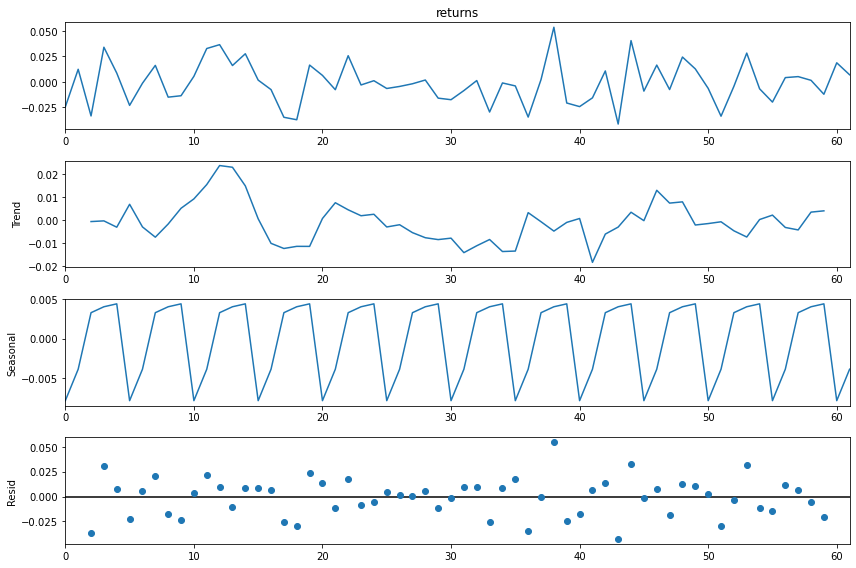

In [206]:
plt.rcParams['figure.figsize'] = (12, 8)
result = seasonal_decompose(apple['returns'], model='additive', period=5)
result.plot()
plt.show();


There seems to some seasonality in data which repeat every few days (5 in this case)

## 1.3 Autocorrelation and Partial Autocorrelation

### Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

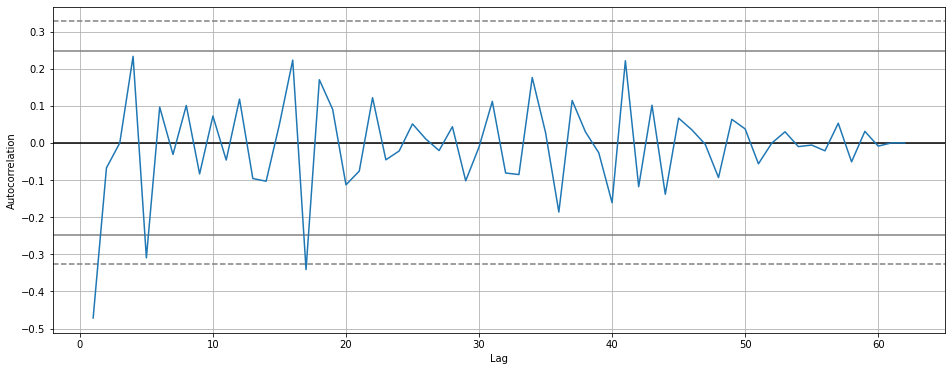

In [207]:
fig, ax = plt.subplots(1,1, figsize = (16,6))
autocorrelation_plot(apple['returns'].diff().fillna(0), ax=ax)

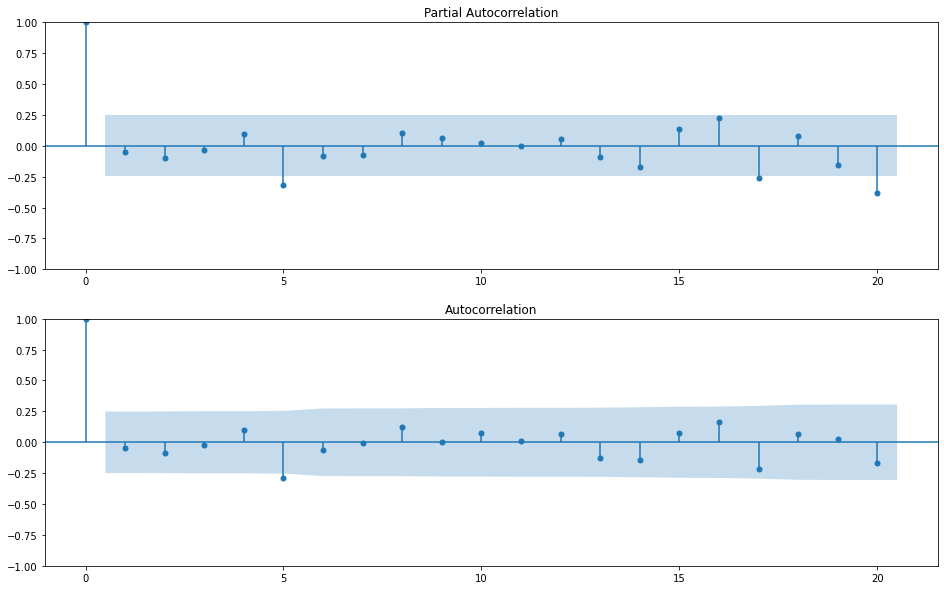

In [208]:
fig, ax = plt.subplots(2,1, figsize = (16,10))
pacf = plot_pacf(apple['returns'].dropna(),lags=20, ax=ax[0])
acf = plot_acf(apple['returns'].dropna(),lags=20, ax=ax[1])

There are Partial Autocorrelation, We explore lags till AR= 5 lags, amd MA=5 lags.

# 2. Time-Series Model
## 2.1 ARIMA model

Three factors define ARIMA model, it is defined as ARIMA(p,d,q) where p, d, and q denote the number of lagged (or past) observations to consider for autoregression, the number of times the raw observations are differenced, and the size of the moving average window respectively.

In [212]:
def plot_actual_forecast_returns(actual, forecast, forecast_variable):
    
    fig, ax = plt.subplots(1,1, figsize = (16,8))

    plt.plot(actual['returns'])
    plt.plot(forecast[forecast_variable])
    ax.axhline(actual['returns'].mean(), linestyle = '--', color = 'k')

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Apple Returns', fontsize=20)
    plt.ylabel('Apple Stock returns', fontsize=16);

    print("Mean Absolute Percent Error(MAPE) {}".format(mean_absolute_percentage_error(
    forecast['returns'], forecast[forecast_variable])))

    print("Root Mean Squared Error(RMSE) {}".format(np.sqrt(mean_squared_error(
    forecast['returns'], forecast[forecast_variable]))))

    print("Weighted Mean Absolute Percentage Error (WMAPE) {}".format(weighted_mean_absolute_percentage_error(
    forecast['returns'], forecast[forecast_variable])))



In [213]:
## Set date as index and seperate the data for train and test
data_arima = apple.set_index('Date')

# for the given period we selected training data till 15th of match and rest is test data on which we would evaluate 
# the model performance 
train_end = datetime(2021, 3, 15)
test_end = datetime(2021, 4, 1)

train_data = data_arima[:train_end]
test_data = data_arima[train_end+timedelta(days = 1):test_end]


### 2.1.1 Rolling Forecast using ARIMA model

Mean Absolute Percent Error(MAPE) 128.11983472231378
Root Mean Squared Error(RMSE) 0.015747064483425652
Weighted Mean Absolute Percentage Error (WMAPE) -2626.741644657645


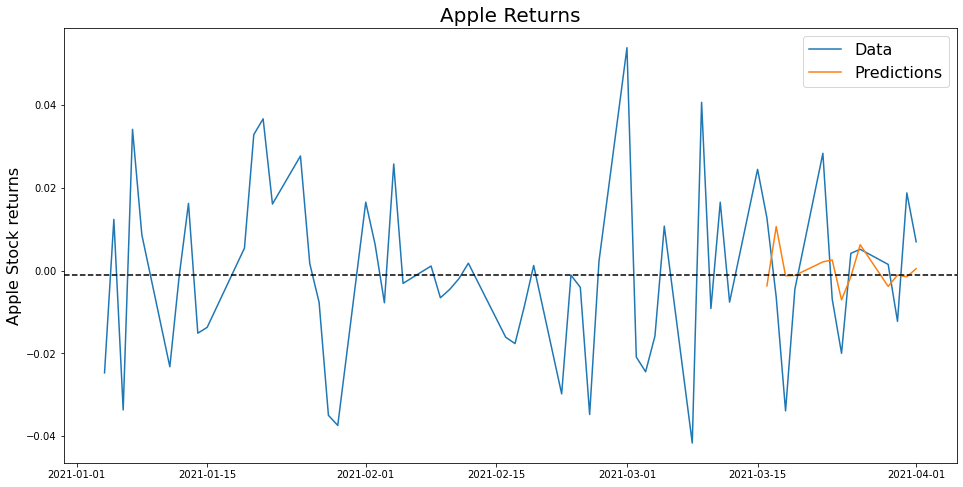

In [214]:
# rolling forecast taking into account actual data to predict next days

rolling_pred_arima = test_data.copy()

for train_end in test_data.index:
    rolling_train_data = data_arima[:train_end - timedelta(days=1)]
    model=ARIMA(rolling_train_data['returns'],order=(1,0,3))
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_pred_arima.loc[train_end,'rolling_forecast_arima'] = pred.item()
    
plot_actual_forecast_returns(data_arima, rolling_pred_arima, 'rolling_forecast_arima')

ARIMA model predictions are poor and it failed to predict the changing patterns, its output is average of returns.
Next we would include seasonality as well and try different models

## 2.2 SARIMA model

* Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.


* It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.


* A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA.


* The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.

In [215]:
## Set date as index and seperate the data for train and test
data_sarima = apple.set_index('Date')

# for the given period we selected training data till 15th of match and rest is test data on 
# which we would evaluate the model performance 
train_end = datetime(2021, 3, 15)
test_end = datetime(2021, 4, 1)

train_data = data_sarima[:train_end]
test_data = data_sarima[train_end+timedelta(days = 1):test_end]


### 2.2.1 Rolling Forecast using SARIMA model

Mean Absolute Percent Error(MAPE) 227.97804019439832
Root Mean Squared Error(RMSE) 0.019370338541811492
Weighted Mean Absolute Percentage Error (WMAPE) -3112.50396750494


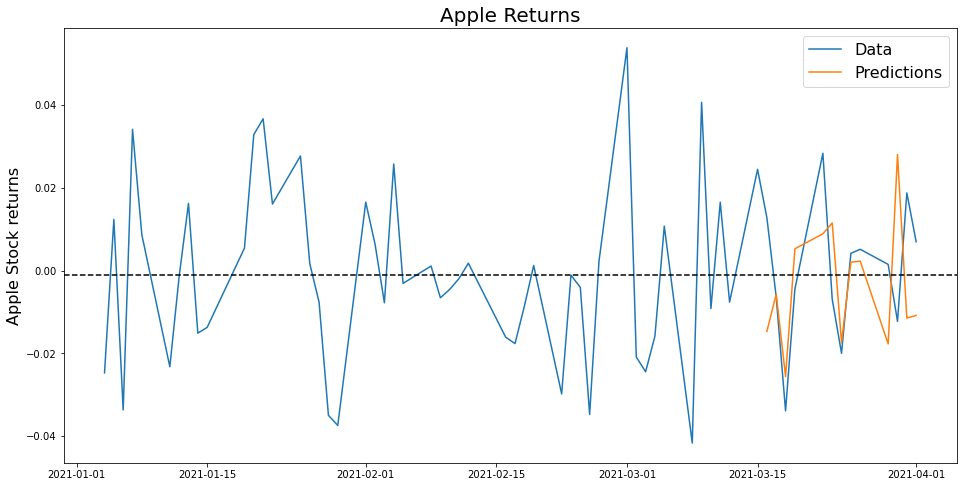

In [216]:
# rolling forecast taking into account actual data to predict next days
rolling_pred_sarima = test_data.copy()

for train_end in test_data.index:
    rolling_train_data = data_sarima[:train_end - timedelta(days=1)]
    model=SARIMAX(rolling_train_data['returns'], order=(1, 0, 3), seasonal_order=(2, 1, 1, 5))
    model_fit = model.fit(disp = 0)
    
    pred = model_fit.forecast()
    rolling_pred_sarima.loc[train_end,'rolling_forecast_sarima'] = pred.item()
    
plot_actual_forecast_returns(data_sarima, rolling_pred_sarima, 'rolling_forecast_sarima')

SARIMA model is able to capture the change is trends better than ARIMA model,
 - We have used seasonality parameter as 5 days
 - Its performace based on MAPE, RMSE and WMAPE is poorer than ARIMA

## 2.3 Prophet model

Prophet was developed by facebook (now meta) for forecasting time series data,
* It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 


* It works best with time series that have strong seasonal effects and several seasons of historical data.


* Prophet is robust to missing data and shifts in the trend, and typically handles

In [217]:
prophet_data = apple.copy(deep = True)
prophet_data = prophet_data.rename(columns= {'Date':'ds', 'returns':'y'})
train_prophet = prophet_data[prophet_data['ds'] <= '2021-03-15']
test_prophet = prophet_data[prophet_data['ds'] > '2021-03-15']

### 2.3.1 Rolling forecast using Prophet Model

Mean Absolute Percent Error(MAPE) 254.42205728276096
Root Mean Squared Error(RMSE) 0.01832604430387924
Weighted Mean Absolute Percentage Error (WMAPE) -3221.0171672599176


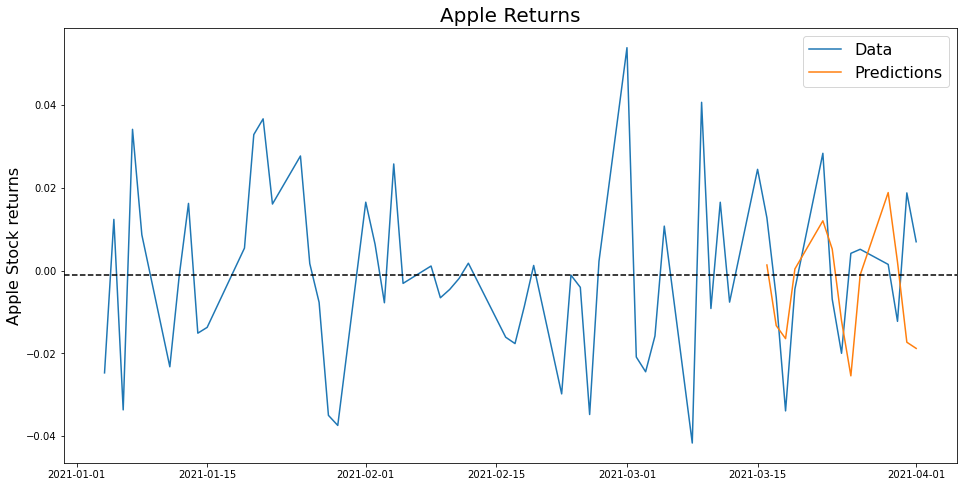

In [218]:
rolling_prophet_forecast = test_prophet.copy(deep = True)

for train_end in test_prophet.index:
    rolling_prophet_data = prophet_data[:train_end - 1]
    prophet_model = Prophet(growth='linear',
                       n_changepoints=20,
                       changepoint_prior_scale=0.1,
                       seasonality_prior_scale=5,
                       seasonality_mode='multiplicative',
                       weekly_seasonality=True)

    prophet_model.fit(rolling_prophet_data)
    future_dataframe = pd.DataFrame(prophet_data[:train_end])
    forecast_prophet = prophet_model.predict(prophet_data[train_end:train_end+1])
    forecast_prophet = forecast_prophet[['ds','yhat']]
    rolling_prophet_forecast.loc[train_end,'rolling_prophet_forecast'] = forecast_prophet['yhat'][0]
    

rolling_prophet_forecast = rolling_prophet_forecast.rename(columns={'ds':'Date','y':'returns'})
rolling_prophet_forecast = rolling_prophet_forecast.set_index('Date')

prophet_data = prophet_data.rename(columns={'ds':'Date','y':'returns'})
prophet_data = prophet_data.set_index('Date')

plot_actual_forecast_returns(prophet_data, rolling_prophet_forecast, 'rolling_prophet_forecast')

We had done hyperparameter tuning to find the best parameter using RMSE as a metrics to optimize
 - Prophet though able to capture the change is trends its performace is still poor
 - Using only returns as feature is not very useful
 - we need to include other exogeneous variables to inhance the performance 

## 2.4 XGBoost model

Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm.
 - In practise this works better for time series data
 - we would need to include additional feature from data (feature engineering) for better prediction

In [219]:
# create a function for feature engineering

# take a dataset and add features
def feature_engineering_xgboost(data):
    
    # get the apple data
    data = data.reset_index()

    # create weekdays
    data['weekdays'] = data['Date'].dt.weekday
    
    ## rolling mean for last 7 days excluding today, min_periods=1 makes sure if 7 days are not available we can take 
    ## rolling mean for 1 day as well
    data['rolling_mean_returns'] = data['returns'].transform(lambda x:x.shift(1).rolling(window = 7, min_periods=1).mean()).astype(np.float16)
    
    ## adding the lags and dummy variables
    # create dummy variables for weekdays and months
    data = pd.get_dummies(data, columns=['weekdays'])
    
    ## adding lags
    lags_range = [1,2,3,4,5,6,7,14,21]
    for i in lags_range:
        data['lag'+str(i)] = data['returns'].shift(i).fillna(data['returns'].mean())


    # variables to include
    variables = [column for column in data.columns
                    if column.startswith(('lag','weekdays'))]
    
    variables.extend(['Adj Close','returns','rolling_mean_returns'])
    data = data.fillna(0)
    data = data.set_index('Date')
    

    return data, variables


In [220]:
train_end = datetime(2021, 3, 15)
val_start = datetime(2021,3,1)
test_end = datetime(2021, 4, 1)

xgb_data = apple.set_index('Date')

train_xgb = xgb_data.loc[:train_end]
val_xgb   = xgb_data.loc[val_start:train_end]
test_xgb  = xgb_data.loc[train_end+timedelta(days=1):]

### 2.4.1 Rolling forecast using XGBoost Model

Mean Absolute Percent Error(MAPE) 180.83444435776397
Root Mean Squared Error(RMSE) 0.018852193043503183
Weighted Mean Absolute Percentage Error (WMAPE) -3149.3592356693166


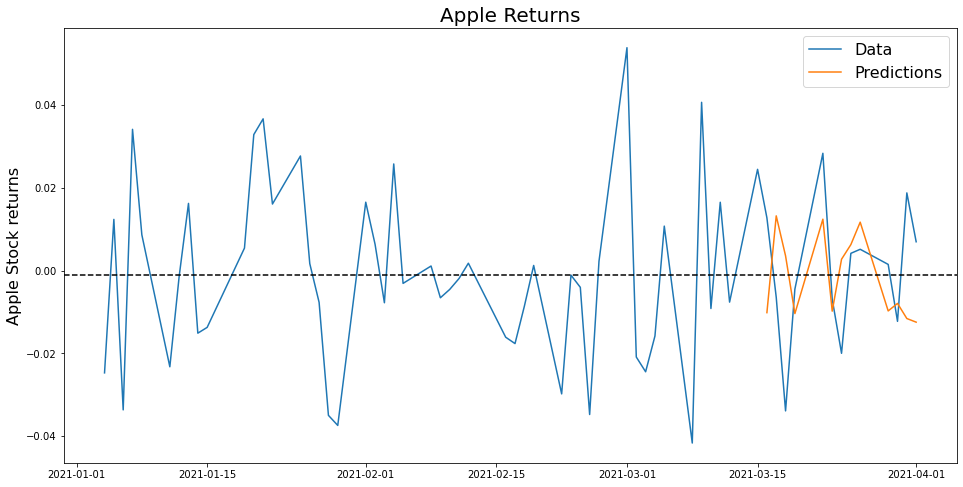

In [221]:

rolling_xgb_forecast = test_xgb.copy()

for train_end in test_xgb.index:
    # get all data this the prediction date (since loc does not include last bound)
    rolling_data = xgb_data.loc[:train_end+timedelta(days=1)]
    
    # add features for forecast, this will return the data with features and variable to include in forecast
    rolling_data, variables = feature_engineering_xgboost(rolling_data)
    
    train_xgb_rolling = rolling_data.loc[:train_end-timedelta(days=1), variables]
    val_xgb_rolling   = rolling_data.loc[val_start:train_end - timedelta(days=1), variables]
    test_xgb_rolling  = rolling_data.loc[train_end:train_end, variables]
    
    X_train = train_xgb_rolling.drop(['returns','Adj Close'], axis=1)
    y_train = train_xgb_rolling['returns']

    X_val = val_xgb_rolling.drop(['returns','Adj Close'], axis=1)
    y_val = val_xgb_rolling['returns']

    X_test = test_xgb_rolling.drop(['returns','Adj Close'], axis=1)
    y_test = test_xgb_rolling['returns']

    model_xgb = xgb.XGBRegressor(learning_rate = 0.01,
                                 max_depth = 15,
                                 min_child_weight = 5,
                                 n_estimators = 2000,
                                 early_stopping_rounds = 50,
                                 eval_metric = 'rmse',
                                 subsample = 0.7)


    model_xgb.fit(X_train, y_train,
                 eval_set = [(X_train, y_train), (X_val, y_val)],
                 verbose = False)
    
    predictions_xgb = model_xgb.predict(X_test)
    rolling_xgb_forecast.loc[train_end, 'rolling_xgb_forecast'] = predictions_xgb

plot_actual_forecast_returns(xgb_data,rolling_xgb_forecast, "rolling_xgb_forecast" )

XGBoost after feature engineering works well,
 - Its able to forecast future returns pattern but its MAPE and RMSE values are high campared to ARIMA model
 - Performance in comparision to other models is not good.

### 2.5 Consolidate results from all models

In [194]:
forecast_all_model = rolling_pred_arima[['Adj Close','returns','rolling_forecast_arima']].copy()
forecast_all_model = forecast_all_model.rename(columns={'rolling_forecast_arima':'Arima'})
forecast_all_model['Sarima'] = rolling_pred_sarima['rolling_forecast_sarima']
forecast_all_model['Prophet'] = rolling_prophet_forecast['rolling_prophet_forecast']
forecast_all_model['Xgboost'] = rolling_xgb_forecast['rolling_xgb_forecast']
forecast_all_model.tail(3)

,Adj Close,returns,Arima,Sarima,Prophet,Xgboost
Date,,,,,,
2021-03-16,124.265900,0.012743,-0.003696,-0.014685,0.001346,-0.010169
2021-03-17,123.464333,-0.006450,0.010643,-0.005692,-0.013294,0.013218
2021-03-18,119.278244,-0.033905,-0.001252,-0.025624,-0.016449,0.003554
2021-03-19,118.743858,-0.004480,-0.001178,0.005269,0.000385,-0.010396
2021-03-22,122.108551,0.028336,0.002097,0.008877,0.012019,0.012410


# 3 Trading Bot

## 3.1. Random Trading Bot

We will test our rule and a random rule for testing period, 

Random rule: randomly decide to buy/sell same day or do nothing: 
            - (0 - Do nothing, 
            - 1-Buy/Sell same day)

In [195]:
### Random Trading Rules
# 0: Do Nothing
# 1: Buy and then sell same day

def random_trading(data):
    money = 100 ## Euro to buy the stocks
    
    for i in range(len(data)-1):
        trading = random.randint(0, 1)

        if trading == 1:
            data.loc[i, 'trading_random'] = 100
        else:
            data.loc[i, 'trading_random'] = 0
            
    data['trading_random'] = data['trading_random'].fillna(0)       
    data['trading_random'] = data['trading_random'].astype(int)
    return data


## 3.2 Rule - 1: Buy-Sell same day

simple rule to buy-sell or do nothing based on forecasted returns

 1: Buy - Sell stocks worth 100 euro on same day - if return is positive <br>
 2: Do nothing -  if return is less rthan zero

In [196]:
def bot_trading(data, model_forecast, trading_actions):
    money = 100 ## worth of stocks which we can buy
    
    for i in range(len(data)-1):
        
        if data.loc[i, model_forecast] > 0:
            data.loc[i, trading_actions] = 100
        else:
            data.loc[i, trading_actions] = 0 # do nothing 
            
    data[trading_actions] = data[trading_actions].fillna(0)       
    data[trading_actions] = data[trading_actions].astype(int)
    return data

def optimum_trading(data):
    money = 100 ## worth of stocks which we can buy
    
    for i in range(len(data)-1):
        
        if data.loc[i, 'returns'] > 0:
            data.loc[i, 'trading_optimum'] = 100
        else:
            data.loc[i, 'trading_optimum'] = 0 # do nothing 
            
    data['trading_optimum'] = data['trading_optimum'].fillna(0)       
    data['trading_optimum'] = data['trading_optimum'].astype(int)
    return data


def stock_returns_calculation(data, trading_rule):
    stock_returns = 0
    for i in range(len(data)):
        stock_returns += data.loc[i, 'returns'] * data.loc[i, trading_rule]
        
    return stock_returns

def average_random_trading(df_random, trading_rule):
    total_random_returns = 0
    trial = 100
    for i in range(trial):
        df_random_trading = random_trading(df_random)
        random_returns = stock_returns_calculation(df_random_trading, trading_rule)
        total_random_returns += random_returns

    return total_random_returns / trial

## 3.3 Rule - 2: Buy-Sell-Hold

We will start with buying stock, then based on returns of next day
 - either sell or hold
 - if sell then buy or hold
 - repeat and in the end sell (if last action was buy)


In [197]:
def trading_bot_rule2(data,start_Adj_close,actual_or_forecast, invest=100):
    stock = 0
    money_left = invest
    today_price = start_Adj_close
    
    # variable to store our last bought action, at start we will buy a stock
    want_to_buy = True
    # variable to store our last sell action, end action should be sell
    want_to_sell = False
    # variable to indicate if we are holding or not?
    hold = False
    
    # store actions taken throughout the trading period
    actions = ["" for j in range(len(data))]
    
    for i in range(len(data)):
        
        # at first we will buy some stocks
        if i == 0:
            actions[0] = 'buy'
            actions[len(data)-1] = 'hold'
            stock = money_left/today_price
            money_left = 0
            want_to_buy = False
            want_to_sell = True
            
        else: # normal situations
            # if wants to sell
            if want_to_sell:
                if data.loc[i, actual_or_forecast] < 0:
                    actions[i] = 'sell' 
                    money_left = stock*today_price
                    stock = 0
                    want_to_buy = True
                    want_to_sell = False
                elif data.loc[i, actual_or_forecast] >= 0: # the price is still increasing, so better to wait 
                     actions[i] = 'hold'                  # more until the higher possible price to sell with
                        
            # if want to buy
            elif want_to_buy:
                if (data.loc[i, actual_or_forecast] > 0) & (i !=len(data)-1) :
                    actions[i] = 'buy'
                    stock = money_left/today_price
                    money_left = 0
                    want_to_buy = False
                    want_to_sell = True
                elif data.loc[i,actual_or_forecast] <=0:
                    actions[i] = 'hold'
                    
        # on the last day sell if last trading was bought            
        if (i == len(data)-1) & (want_to_buy==False):
            actions[i] = 'sell'
            money_left = stock*today_price
            stock = 0
            
                    
        # update today's price
        today_price = data.iloc[i]['Adj Close']
                    
                    
#     print("Our final Profit ! {}".format(money_left-invest))
#     print("Our invest  {}".format(invest))
#     print("Our stock  {}".format(stock))
    data['actions'] = actions
    return data, (money_left-invest)     

# 4 Models evaluation - on profit

### 4.1 Random Bot performance 

In [198]:
data_trading = forecast_all_model.reset_index()
random_bot_result = np.round(average_random_trading(data_trading, 'trading_random'),2)
print(f'Average Returns in trading period using Random Trading: {random_bot_result}')

Average Returns in trading period using Random Trading: -0.72


For the random trading we invested 100 Euro
 - the return after trading period of 13 days was in negative
 - surely random trading would not perform better, but it creates our lower bound to compare model performance.
 

### 4.2 Trading Bot - Rule1 (Buy-Sell same day) performance 

In [199]:
# variable to get optimum profit based on Rule-1
trading_optimum = 'trading_optimum'

arima_profit   = np.round(stock_returns_calculation(bot_trading(data_trading, 'Arima','trading_arima'), 'trading_arima'),2)
sarima_profit  = np.round(stock_returns_calculation(bot_trading(data_trading, 'Sarima','trading_sarima'), 'trading_sarima'),2)
prophet_profit = np.round(stock_returns_calculation(bot_trading(data_trading, 'Prophet','trading_prophet'), 'trading_prophet'),2)
xgboost_profit = np.round(stock_returns_calculation(bot_trading(data_trading, 'Xgboost','trading_xgboost'), 'trading_xgboost'),2)
optimum_profit = np.round(stock_returns_calculation(optimum_trading(data_trading), trading_optimum),2)

print(f'Returns from trading period using   ARIMA model: {arima_profit}')
print(f'Returns from trading period using  SARIMA model: {sarima_profit}')
print(f'Returns from trading period using PROPHET model: {prophet_profit}')
print(f'Returns from trading period using XGBoost model: {xgboost_profit}')

print('-------------------------------------------------')
print(f'Optimum Returns possible using trading Rule-1 (Buy-Sell same day): {optimum_profit}')

Returns from trading period using   ARIMA model: 2.01
Returns from trading period using  SARIMA model: 1.4
Returns from trading period using PROPHET model: 1.89
Returns from trading period using XGBoost model: -2.27
-------------------------------------------------
Optimum Returns possible using trading Rule-1 (Buy-Sell same day): 7.06


 - From the trading bot Rule-1 (Buy-Sell same day or do nothing) wer are getting an optimum return of 7.06 euro for 100 euro investment
 - ARIMA model outperforms other algorithms in terms of profit
 - Prophet model is second with profit of 1.89 euro
 - SARIMA model and XGBoost model though able to capture the trends of returns but did not perform well

### 4.3 Trading Bot - Rule2 (Buy-Sell-Hold) performance 

In [200]:
data_trading_rule2 = forecast_all_model.reset_index()
start_Adj_close = train_data.iloc[-1]['Adj Close']
actual_returns = 'returns'
forecast_returns = 'rolling_forecast'
invest = 100

rule2_df_arima, arima_profit_rule2     = trading_bot_rule2(data_trading_rule2,start_Adj_close,  'Arima', invest)
rule2_df_sarima, sarima_profit_rule2   = trading_bot_rule2(data_trading_rule2,start_Adj_close, 'Sarima', invest)
rule2_df_prophet, prophet_profit_rule2 = trading_bot_rule2(data_trading_rule2,start_Adj_close,'Prophet', invest)
rule2_df_xgboost, xgboost_profit_rule2 = trading_bot_rule2(data_trading_rule2,start_Adj_close,'Xgboost', invest)
rule2_df_optimum, opptimum_profit_rule2 = trading_bot_rule2(data_trading_rule2,start_Adj_close,'returns', invest)

print(f'Returns from trading period using   ARIMA model: {np.round(arima_profit_rule2,2)}')
print(f'Returns from trading period using  SARIMA model: {np.round(sarima_profit_rule2,2)}')
print(f'Returns from trading period using PROPHET model: {np.round(prophet_profit_rule2,2)}')
print(f'Returns from trading period using XGBoost model: {np.round(xgboost_profit_rule2,2)}')

print('-------------------------------------------------')
print(f'Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold): {np.round(opptimum_profit_rule2,2)}')



Returns from trading period using   ARIMA model: 3.29
Returns from trading period using  SARIMA model: 2.65
Returns from trading period using PROPHET model: 1.85
Returns from trading period using XGBoost model: -1.12
-------------------------------------------------
Optimum Returns possible using trading Rule-2 (Buy-Sell-Hold): 7.25


Using Rule-2 (Buy-Sell-Hold), we have included a hold option for bot, if market is going up its better to hold the stock and sell at higher price "Buy Low Sell High".
 - We have improved our profit to 3.29 euro for 100 euro investment
 - ARIMA model again outperforms other models
 - Prophet model is performing reasoning well but need more features (internal or external information)

# 5 Conclusion

For all the stocks we are getting profit which is close to optimum
 - For the same trading period and investment google provides more profit compared to apple and amazon
 - More complex rule using short selling could improve the net return, this need to be explored
 - ARIMA model performs well for returns forecasting
 - Its seems to be robust even for different period of time
 - Future steps would invove using Neural Network (NN) like Long Short Term Memory (LSTM) and having more sopisticated trading algorithum which not only consider historical data but also external input like correlation with other stocks price, technological changes, pandemic etc.